# Abstract

This document proposes a robust way to calculate precision and recall. We use straightforward Bayesian techniques to turn results from a cross validation, into a pair of distributions over the precision and recall of the model when used on a dataset with a different distribution of classes to that in the dataset.

In [11]:
import pandas as pd
from IPython.display import display, Markdown
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

# Binary Classification Problems

In this section we'll use EV detection as a motivating example. The output is `true` or `false`, depending on whether the household has an EV or not respectively.

## Single Train/Test Split, No Bounds

Assume we have a single train/test split, that we've trained a model, that we've generated predictions and so ended up with the following confusion matrix

In [4]:
from ast import Mult

from pandas import MultiIndex

def make_cm(tp, fp, fn, tn) -> pd.DataFrame:
    return pd.DataFrame(
        [[tp, fp],
        [fn, tn],
        [tp+fn, fp+tn]],
        columns=pd.MultiIndex.from_tuples(
            [('Actual', 'Positive'), ('Actual', 'Negative')],
        ),
        index=pd.MultiIndex.from_tuples(
            [('Predicted', 'True'),
            ('Predicted', 'False'),
            ('Total', '')]
        )
    )

cm = make_cm(53, 27, 17, 93)
tp = lambda df: df.iloc[0, 0]
fp = lambda df: df.iloc[0, 1]
fn = lambda df: df.iloc[1, 0]
tn = lambda df: df.iloc[1, 1]
cm

Actual         
                Positive Negative
Predicted True        53       27
          False       17       93
Total                 70      120

For reference, we denote by $N^+$ and $N^-$ the total number of positive and negative samples, and by by $N = N^+ + N^-$ the total size of the validation dataset used to construct the validation confusion matrix.

The simple definitions of precision and recall are

$$
\begin{aligned}
Prec &= \frac{TP}{TP + FP} \\
Rec & = \frac{TP}{TP + FN} = \frac{TP}{N^+}
\end{aligned}
$$

Where TP, FP, TN and FN refer to true-positives, false-positive, true-negatives and false-negatives respectively.

This gives us the following

In [5]:
pd.DataFrame({
    'Precision': [tp(cm) / (tp(cm) + fp(cm))],
    'Recall': [tp(cm) / (tp(cm) + fn(cm))]
}).T.round(2).rename(columns={0:''})

,
Precision,0.66
Recall,0.76


## Single Train/Test Split, With Bounds

In our definitions of precision and recall

 * $TP$ and $FP$ are unknowable random variables
 * $N^+$ and $N^-$ the number of positive and negative cases in the validation dataset, are known observed quantities.
 * $FN = N^+ - TP$ and $TN = N^- - FP$ are derived random variables.

Specifically for our model, if we let $y$ and $\hat{y}$ refer to actual and predicted values respectively, then

$$
\begin{aligned}
p(\hat{y}=1|y=1) & = \tau \qquad &  p(\hat{y}=1|y=0) & = \phi \\
p(\hat{y}=0|y=1) &= 1 - \tau\qquad & p(\hat{y}=0|y=0) &= 1 - \phi
\end{aligned}
$$

Note that $\tau$ is in fact a different way of defining the _recall_ metric, also known as _sensitivity_ or _true-positive rate_ (TPR). Similarly $1 - \phi$ is the negative recall, or _specificity_ or _true-negative rate_ (TNR).

Note also that the definitions of the true-positive rate and true-negative rate are both invariant to the proportion of positive to negative samples in the dataset.

Taking the Bayesian approach, we can establish the prior, likelihood, and posterior distributions

$$
\begin{aligned}
\tau & \sim Beta(\alpha_0, \beta_0) &
\phi & \sim Beta(\lambda_0, \psi_0) \\
TP & \sim Bin(\tau; P) &
FP & \sim Bin(\phi; N) \\
\tau|\mathcal{Y} & \sim Beta(\alpha_N, \beta_N) &
\phi|\mathcal{Y} & \sim Beta(\lambda_N, \psi_N) \\
\end{aligned}
$$

While [there's a lot that can be said about what consitutes a non-informative prior](https://stats.stackexchange.com/a/298176), in practice if the choice of priors over $\tau$ or $\phi$ could meaningfully affect our end result, then we wouldn't have enough data to be making any decisions from in the first place.

So we just use flat, weak Beta distributions and use the standard conjugate formalas to obtain the parameterisations of the posteriors too

$$
\begin{aligned}
\tau & \sim Beta(1, 1) &
\phi & \sim Beta(1, 1) \\
\tau|\mathcal{X} & \sim Beta(1 + TP, 1 + FN) &
\phi|\mathcal{X} & \sim Beta(1 + FP, 1 + TN) \\
\end{aligned}
$$

From this it's trivial to create Bayesian estimates of Recall.

The expected recall is just 

$$
\begin{aligned}
\mathbb{E}_{\tau|\mathcal{Y}}[\tau]
& = \frac{\alpha_N}{\alpha_N + \beta_N} \\
& = \frac{1 + TP}{2 + TP + FN}
\end{aligned}
$$

And we can easily create a credibility interval by just obtaining the quantiles from the distribution $Beta(1 + TP, 1 + FN)$

Precision is harder to calculate. 

We need to obtain an estimate for 

$$
\begin{aligned}
\mathbb{E}_{\tau, \phi|\mathcal{Y}}[
    \frac{TP}{TP + FP}
] = 
\mathbb{E}_{\tau, \phi|\mathcal{Y}}[
    \frac{\tau P}{\tau P + \phi N}
]
\end{aligned}
$$
where $FP = \phi N^-$ 

(recall $N^-$ is the count of negative samples, and $\phi = p(\hat{y}=1|y=0)$)


As far as I can see, even with the independence assumption between $\tau$ and $\phi$, there is no way to analytically solve or approximate this integral, hence we just use sampling

$$
\begin{aligned}
\mathbb{E}_{\tau, \phi|\mathcal{X}}[
    \frac{TP}{TP + FP}
] 
& \approx \frac{1}{S} \sum_{s=1}^S \frac{\tau^{(s)}P}{\tau^{(s)}P + {\phi^{(s)}N}} \qquad
& \tau^{(s)},\phi^{(s)} & \sim p(\tau|\mathcal{X})p(\psi|\mathcal{X}) 
\end{aligned}
$$

We can also use sampling to approximate the quantiles of the distribution.

This allows us to derive bounded estimates of our precision and recall.

In [6]:
a, b = 1 + tp(cm), 1 + fn(cm)

l, s = 1 + fp(cm), 1 + tn(cm)

recall = stats.beta(a, b).mean()
recall_l, recall_u = stats.beta(a, b).ppf([0.025, 0.975])

P, N = cm.iloc[-1, :]

SAMPLE_SIZE = 1000
prec_samples = pd.Series([
    (t *  P) / (t * P + f * N)
    for t, f in zip(
        stats.beta(a, b).rvs(SAMPLE_SIZE),
        stats.beta(l, s).rvs(SAMPLE_SIZE)
    )
])
prec = prec_samples.mean()
[prec_l, prec_u] = prec_samples.quantile([0.025, 0.975])

In [7]:
pd.DataFrame(
    [
        [prec_l, prec, prec_u],
        [recall_l, recall, recall_u]
    ],
    columns=['2.5th', 'Mean', '97.5th'],
    index=['Precision', 'Recall']
).round(2)

,2.5th,Mean,97.5th
Precision,0.58,0.66,0.74
Recall,0.64,0.75,0.84


## Single Train/Test Split, With Bounds, Adjusted for Population

Till now, our evaluation methods have assumed that the distribution of data in the dataset matches the distribution of data in the real world.

In reality this isn't the case: in our dataset 37% of households have EVs; in the real world 3% of households have EVs; but amongst our UK customers, 10% of housholds have reported having EVs.

So lets assume that the population to whom the model is deployed is one in which roughly 8-12% of users have EVs. We can (very coarsely) approximate this with a $Beta(a_{pop}=110, b_{pop}=1000)$ distribution whose 1st and 99th percentiles are 0.08 and 0.12 respectively.

Alternatively we could just use a uniform distribution on the closed interval $[0.08, 0.12]$, since -- as we'll see later -- there's no (obvious) analytical benefit in using the Beta distribution

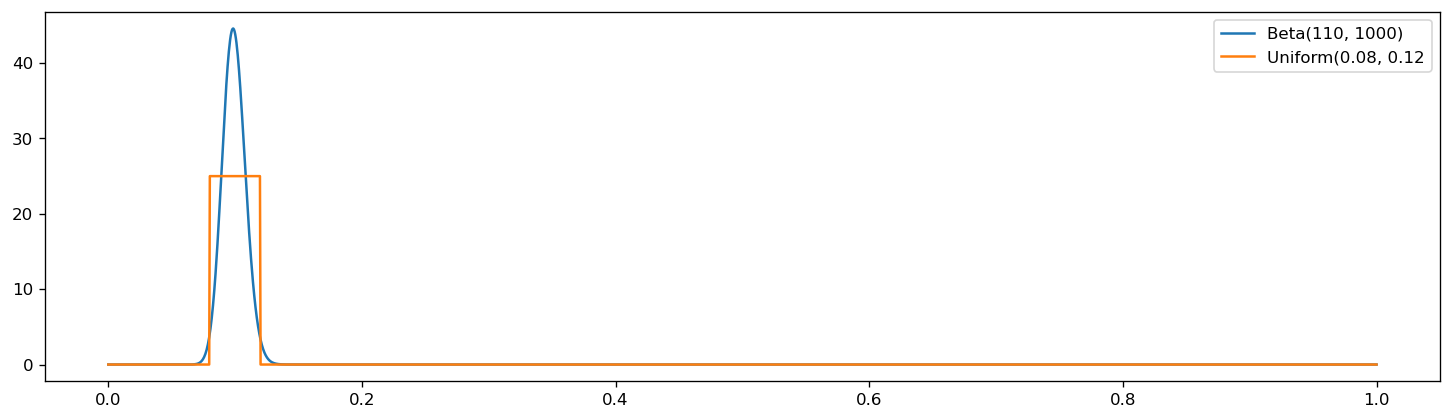

In [22]:
xs = np.linspace(0, 1.00, 2000)
beta_ys = stats.beta(110, 1000).pdf(xs)

uni_ys = np.full_like(beta_ys, 1 / (0.12 - 0.08))
uni_ys[xs < 0.08] = 0
uni_ys[xs > 0.12] = 0

fig, ax = plt.subplots(figsize=(15, 4), dpi=120)
ax.plot(xs, beta_ys, label="Beta(110, 1000)")
ax.plot(xs, uni_ys, label="Uniform(0.08, 0.12")
ax.legend();

Given the state of our uncertainty, the vaguer uniform is probably the more advisable choice.

Assuming our distribution of the proportion of population that falls in the positive case is

$$
\rho \sim U(0.08, 0.12)
$$

But the proportion in our dataset is $r = \frac{N^+}{N^-}$

We already know that distribution over recall will not change as we move from one population to the next, since the true-positive rate is invariant to the mix of true and negative samples in a population

So only precision will change. 

Our task is to evaluate precision on the a dataset with the statistics of the population, but our actual dataset is different.

If we denote the empirical distribution of samples from our dataset be denoted $q(y)$ and the distribution of samples from the (unobserved) population is $p(y)$, then 

$$
\begin{aligned}
TP = \int \frac{}
\end{aligned|}
$$